# Kopp et al 2021 Plotting 
**Authorship:**
Adam Klie, *08/12/2022*
***
**Description:**
Notebook to generate plots for the Kopp et al (2021) dataset that are not included in the other notebooks.
- Performance figures
- Nicer seq track and filter visualizations
- Inspect and merge TomTom annotations
***

In [30]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# General imports
import os
import sys
import numpy as np
import pandas as pd
from copy import deepcopy
from itertools import groupby
from operator import itemgetter
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests

# EUGENe imports and settings
import eugene as eu
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/kopp21"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/kopp21"
settings.logging_dir = "/cellar/users/dlaub/projects/ML4GLand/EUGENe_paper/logs/kopp21"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/kopp21"

# EUGENe packages
import seqdata as sd
import motifdata as md

# For illustrator editing
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Print versions
print(f"Python version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Eugene version: {eu.__version__}")
print(f"SeqData version: {sd.__version__}")

Python version: 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
NumPy version: 1.23.5
Eugene version: 0.0.8
SeqData version: 0.0.1


# Load in the test `SeqData`(s)

In [6]:
# Read in the predictions 
predictions = pd.read_csv(os.path.join(settings.output_dir, "test_predictions.tsv"), sep="\t", index_col=0)
sdata_test = sd.open_zarr(os.path.join(settings.output_dir, "test_predictions.zarr")).load()

# Generate performance figures

In [7]:
# Get only variables with "predictions" in the name
preds_keys = [k for k in sdata_test.keys() if "predictions" in k]

In [8]:
preds_keys

['cnn_trial_1_target_predictions',
 'fcn_trial_1_target_predictions',
 'hybrid_trial_1_target_predictions',
 'kopp21_cnn_trial_1_target_predictions']

In [21]:
# Order the pred_keys from in this order ["cnn", "hyrbrid", "kopp21_cnn", "deepstarr"]
order = ["fcn", "kopp21_cnn", "hybrid", "cnn"]
pred_models = [k.split("_")[0] if "kopp21" not in k else "kopp21_cnn" for k in preds_keys]
pred_models = [order.index(m) for m in pred_models]
preds_keys = [k for _, k in sorted(zip(pred_models, preds_keys))]

# Get groups based io
model_groups = {"fcn": "fcn", "kopp21_cnn": "kopp21_cnn", "hybrid": "hybrid", "cnn": "cnn"}
groups = [model_groups[k.split("_")[0]] if "kopp21" not in k else "kopp21_cnn" for k in preds_keys]

In [18]:
sdata_test["id"] = sdata_test["chrom"] + ":" + sdata_test["chromStart"].astype(str) + "-" + sdata_test["chromEnd"].astype(str)

In [16]:
sdata_test

<xarray.Dataset>
Dimensions:                                (_sequence: 64309, cov_sample: 1,
                                            _length: 500, length: 500, _ohe: 4)
Coordinates:
  * cov_sample                             (cov_sample) object 'stam'
Dimensions without coordinates: _sequence, _length, length, _ohe
Data variables: (12/13)
    chrom                                  (_sequence) object 'chr3' ... 'chr3'
    chromEnd                               (_sequence) int64 1394750 ... 1980...
    chromStart                             (_sequence) int64 1394250 ... 1980...
    cnn_trial_1_target_predictions         (_sequence) float32 -3.696 ... -5.524
    cov                                    (_sequence, cov_sample, _length) uint16 ...
    fcn_trial_1_target_predictions         (_sequence) float32 -3.299 ... -3.942
    ...                                     ...
    kopp21_cnn_trial_1_target_predictions  (_sequence) float32 -3.373 ... -4.542
    ohe_seq                                (_sequence, length, _ohe) uint8 1 ...
    seq                                    (_sequence, _length) |S1 b'A' ... ...
    strand                                 (_sequence) object '+' '+' ... '+'
    target                                 (_sequence) uint8 0 0 0 0 ... 0 0 0 0
    train_test                             (_sequence) bool False ... False
Attributes:
    length_dim:    _length
    max_jitter:    0
    sequence_dim:  _sequence

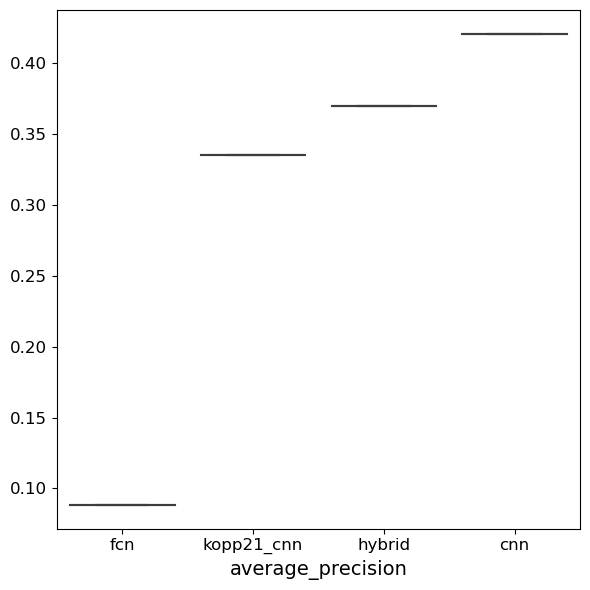

In [25]:
model_scores = pl.performance_summary(
    sdata_test,
    target_key="target",
    prediction_keys=preds_keys,
    prediction_groups=groups,
    order=order,
    metrics=["average_precision"],
    figsize=(6, 6),
    save=os.path.join(eu.settings.figure_dir, "auprc_boxplot.pdf")
)

In [ ]:
# Test distributions for significant differences
pairwise_tests = []
compare_df = model_scores.pivot(columns="prediction_groups", values="average_precision")
pairwise_tests.append(mannwhitneyu(compare_df["dsFCN"].dropna(), compare_df["Kopp21CNN"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["dsFCN"].dropna(), compare_df["dsHybrid"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["dsFCN"].dropna(), compare_df["dsCNN"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["Kopp21CNN"].dropna(), compare_df["dsHybrid"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["Kopp21CNN"].dropna(), compare_df["dsCNN"].dropna()).pvalue)
pairwise_tests.append(mannwhitneyu(compare_df["dsHybrid"].dropna(), compare_df["dsCNN"].dropna()).pvalue)
multipletests(pairwise_tests, alpha=0.05, method="fdr_bh")

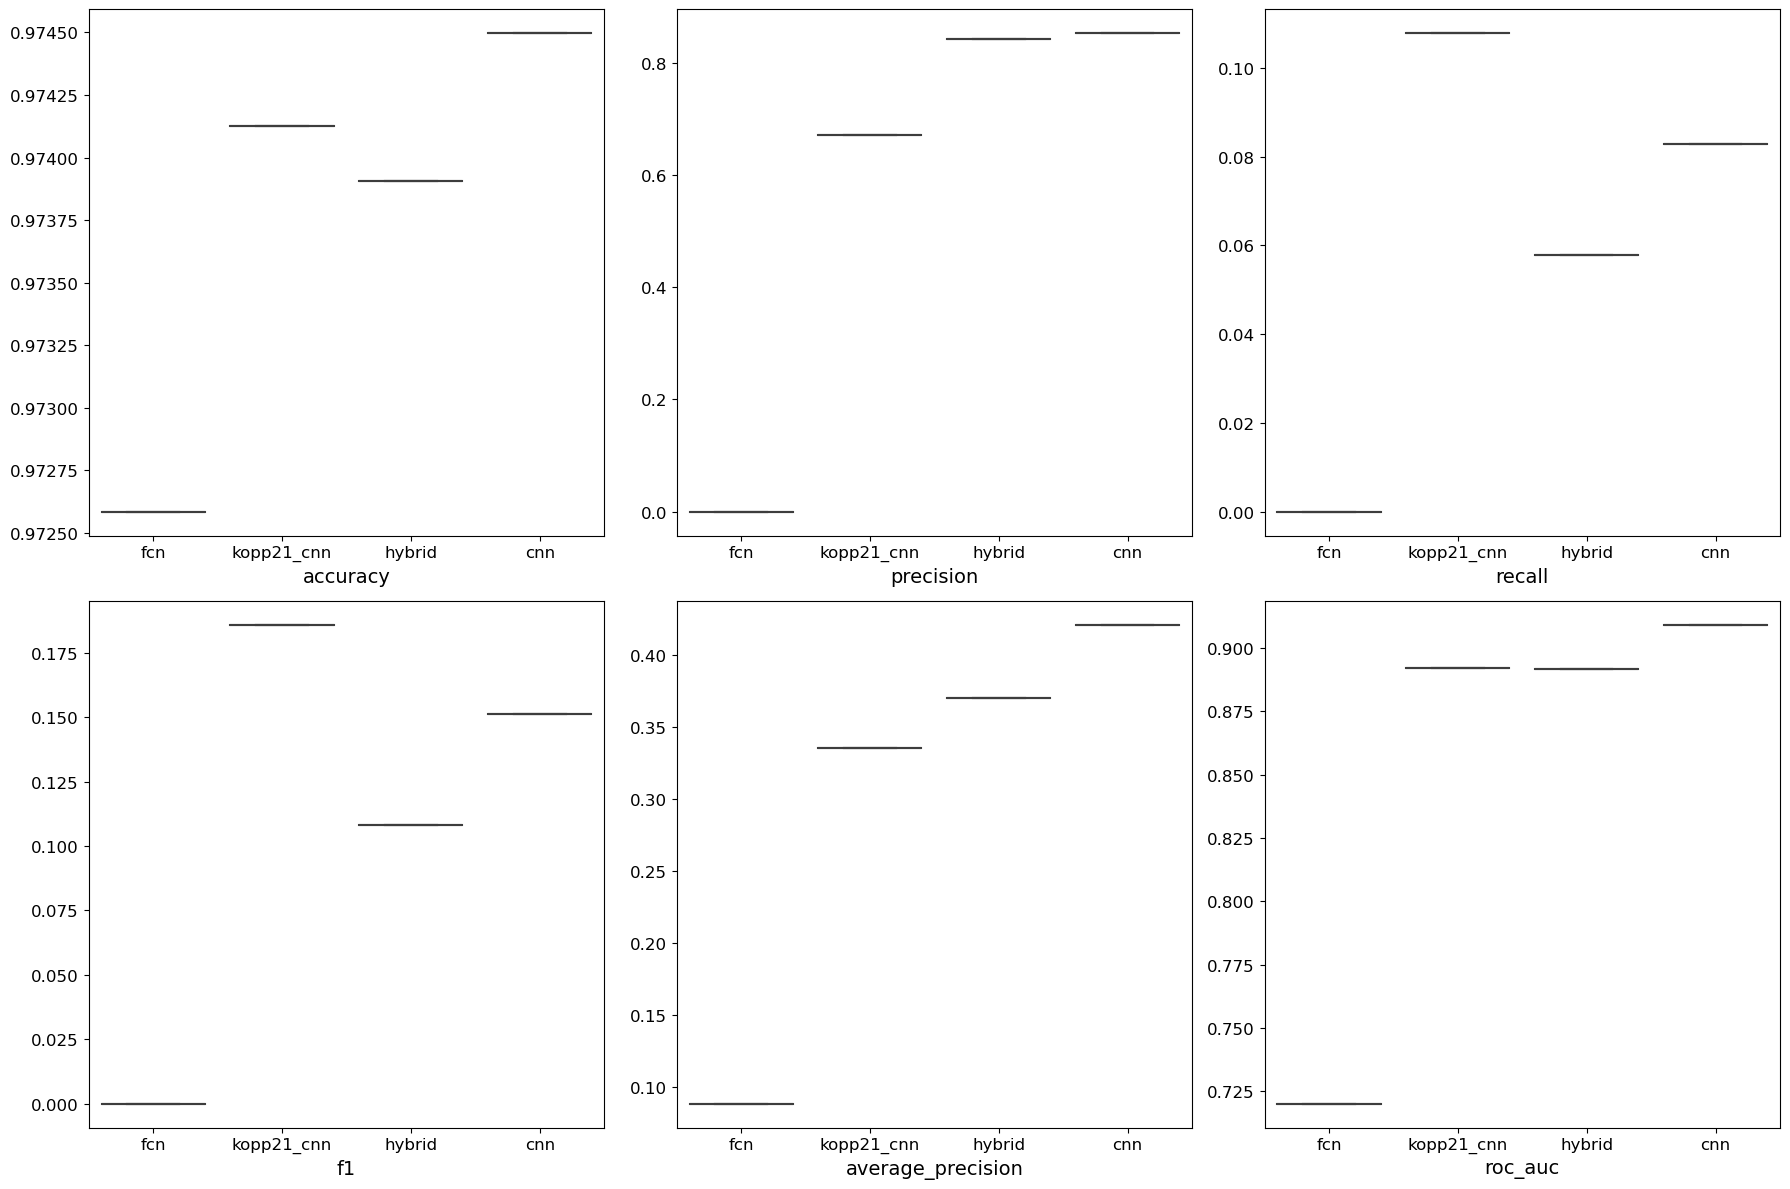

In [26]:
model_scores = pl.performance_summary(
    sdata_test,
    target_key="target",
    prediction_keys=preds_keys,
    prediction_groups=groups,
    order=order,
    metrics=["accuracy", "precision", "recall", "f1", "average_precision", "roc_auc"],
    figsize=(6, 6),
    save=os.path.join(eu.settings.figure_dir, "auprc_boxplot.pdf")
)

In [27]:
# Save model performance as table
model_scores.to_csv(os.path.join(eu.settings.output_dir, "performance_summary.tsv"), sep="\t")

<AxesSubplot: ylabel='auPRC'>

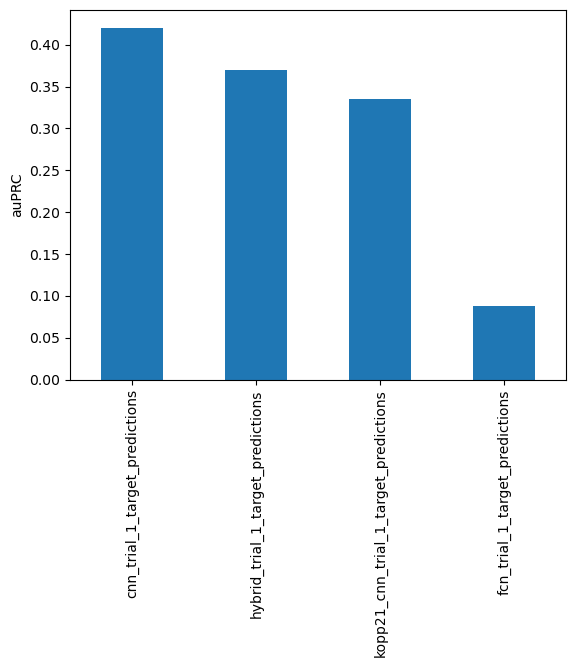

In [28]:
# Identify the best model from returned model scores
auprc_sorted = model_scores["average_precision"].sort_values(ascending=False)
auprc_sorted.plot(kind="bar", ylabel="auPRC")

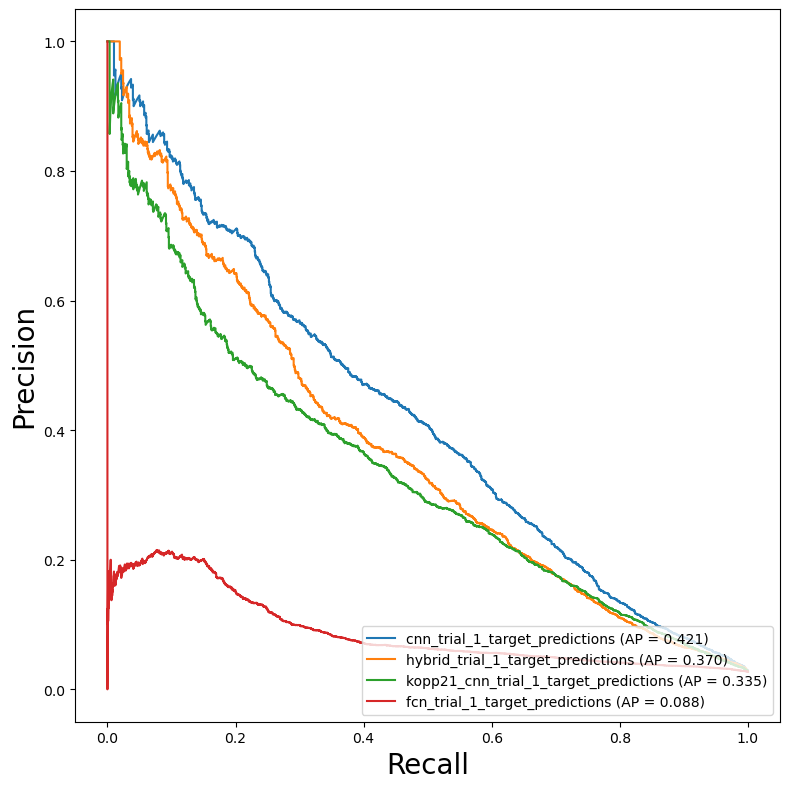

In [31]:
# Plot the performances across species for the best model
model_scores["model_type"] = [model.split("_")[0] for model in model_scores.index]
best_preds = model_scores.sort_values(by="average_precision", ascending=False).groupby("model_type").head(1).index
pl.auprc(
    sdata_test,
    target_keys=["target"]*4, 
    prediction_keys=best_preds,
    labels=best_preds,
    save=os.path.join(eu.settings.figure_dir, "best_model_auprc.pdf")
)
plt.show()

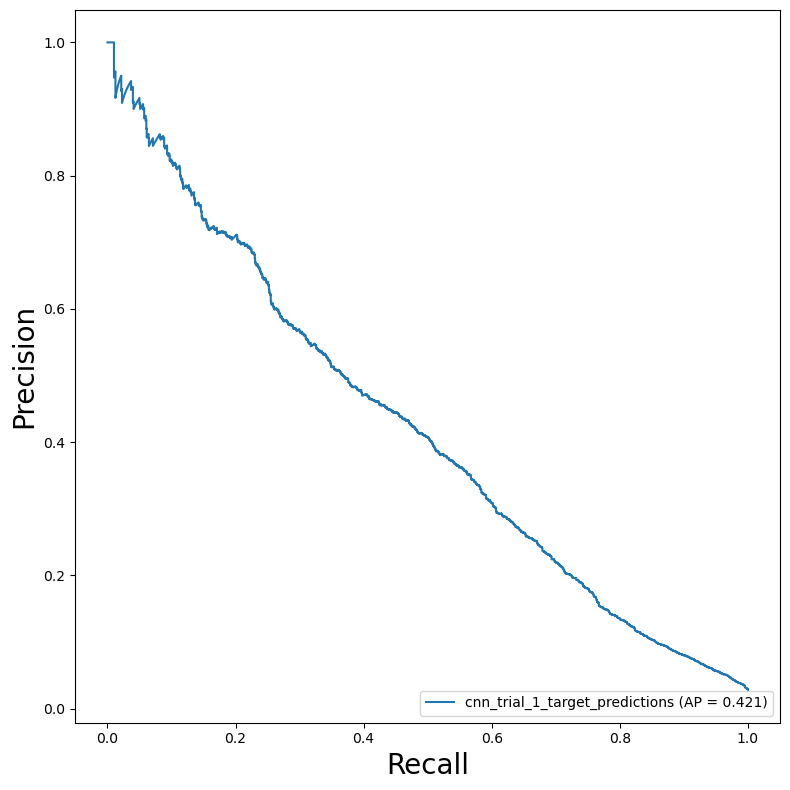

In [32]:
# Plot the performances across species for the best model
pl.auprc(
    sdata_test,
    target_keys="target",
    prediction_keys=best_preds[0],
    labels=best_preds[0],
    save=os.path.join(eu.settings.figure_dir, "best_single_model_auprc.pdf")
)
plt.show()

# Seq track visualizations

In [34]:
# Choose the model and the test data
model_type = "cnn"
trial = 1
sdata_test = sd.open_zarr(os.path.join(eu.settings.output_dir, model_type, f"test_predictions_and_interpretations.zarr"))

In [38]:
# From the top 10 predicted sequences, identify the positions where we see significant attribution signal
top10 = sdata_test[f"{model_type}_trial_{trial}_target_predictions"].to_series().sort_values(ascending=False).iloc[:10].index
top10_idx = np.argsort(sdata_test[f"{model_type}_trial_{trial}_target_predictions"].values)[::-1][:10]
np.where(np.sum(sdata_test["GradientShap_attrs"][top10_idx], axis=1) > 0.1)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7,
        7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8,
        8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
        8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9]),
 array([ 59,  86, 251, 287, 308, 310, 311, 316, 323, 324, 325, 326, 327,
        328, 329, 330, 339, 340, 342, 351,  47,  48,  49,  51, 194, 211,
        212, 213, 214, 215, 216, 217, 218, 219, 228, 283, 394, 402, 411,
        412, 413, 414, 415, 416, 417, 418, 419, 420, 422, 423, 424, 425,
        427, 428, 436, 464, 466, 413, 419, 420, 421, 422, 423, 425, 426,
        427, 170, 171, 172, 173, 174, 175, 176, 177, 276, 329, 168, 169,
        170, 171, 1

In [49]:
sdata_test

<xarray.Dataset>
Dimensions:                                (_sequence: 64309, _ohe: 4,
                                            length: 500,
                                            _arch.conv1d_tower.layers.1_10_filters: 10,
                                            _arch.conv1d_tower.layers.1_11_kernel_size: 11,
                                            cov_sample: 1, _length: 500)
Coordinates:
  * cov_sample                             (cov_sample) object 'stam'
Dimensions without coordinates: _sequence, _ohe, length,
                                _arch.conv1d_tower.layers.1_10_filters,
                                _arch.conv1d_tower.layers.1_11_kernel_size,
                                _length
Data variables: (12/16)
    GradientShap_attrs                     (_sequence, _ohe, length) float32 dask.array<chunksize=(8039, 1, 63), meta=np.ndarray>
    arch.conv1d_tower.layers.1_pfms        (_arch.conv1d_tower.layers.1_10_filters, _arch.conv1d_tower.layers.1_11_kernel_size, _ohe) float32 dask.array<chunksize=(10, 11, 4), meta=np.ndarray>
    chrom                                  (_sequence) object dask.array<chunksize=(32155,), meta=np.ndarray>
    chromEnd                               (_sequence) int64 dask.array<chunksize=(32155,), meta=np.ndarray>
    chromStart                             (_sequence) int64 dask.array<chunksize=(32155,), meta=np.ndarray>
    cnn_trial_1_target_predictions         (_sequence) float32 dask.array<chunksize=(64309,), meta=np.ndarray>
    ...                                     ...
    ohe_seq                                (_sequence, length, _ohe) uint8 dask.array<chunksize=(8039, 125, 1), meta=np.ndarray>
    seq                                    (_sequence, _length) |S1 dask.array<chunksize=(8039, 125), meta=np.ndarray>
    strand                                 (_sequence) object dask.array<chunksize=(32155,), meta=np.ndarray>
    target                                 (_sequence) uint8 dask.array<chunksize=(64309,), meta=np.ndarray>
    train_test                             (_sequence) bool dask.array<chunksize=(64309,), meta=np.ndarray>
    id                                     (_sequence) <U8 'seq00000' ... 'se...
Attributes:
    length_dim:    _length
    max_jitter:    0
    sequence_dim:  _sequence

In [43]:
from eugene import preprocess as pp

In [44]:
pp.make_unique_ids_sdata(sdata_test)

In [47]:
ids = sdata_test["id"].values

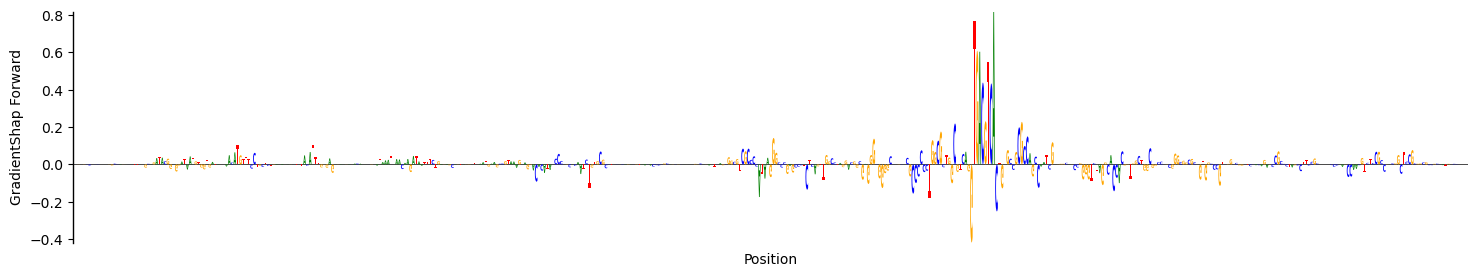

In [52]:
# Use the ouptut from above to highlight specific seqlets
pl.seq_track(
    sdata_test,
    seq_id=ids[top10[1]],
    attrs_key="GradientShap_attrs",
    ylab="GradientShap Forward",
    figsize=(18, 3),
    #highlights=[(387, 400)],
    highlight_colors = ["lightcyan"],
    #save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_GradientSHAP_forward_imps_top1_with_color.pdf")
)

In [ ]:
# Repeat for the reverse strand
np.where(np.sum(sdata_test.uns["GradientSHAP_reverse_imps"][top10_idx], axis=1) > 0.1)

In [ ]:
eu.pl.seq_track(
    sdata_test,
    seq_id=top2[0],
    uns_key="GradientSHAP_reverse_imps",
    ylabel="GradientSHAP Reverse",
    figsize=(18, 3),
    highlights=[(105,114), (178, 190)],
    highlight_colors = ["lightcyan", "honeydew"],
    save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_GradientSHAP_reverse_imps_top1_with_color.pdf")
)

In [ ]:
# Plot all top 10 and save
for i, seq in enumerate(top10):
    eu.pl.seq_track(
        sdata_test,
        seq_id=top10[i],
        uns_key="GradientSHAP_forward_imps",
        ylabel="GradientSHAP Forward",
        figsize=(18, 3),
        save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_GradientSHAP_forward_imps_top{i+1}.pdf")
    )
    eu.pl.seq_track(
        sdata_test,
        seq_id=top10[i],
        uns_key="GradientSHAP_reverse_imps",
        ylabel="GradientSHAP Reverse",
        figsize=(18, 3),
        save=os.path.join(eu.settings.figure_dir, f"jund_best_{model_type}_model_GradientSHAP_reverse_imps_top{i+1}.pdf")
    )

# Filter viz

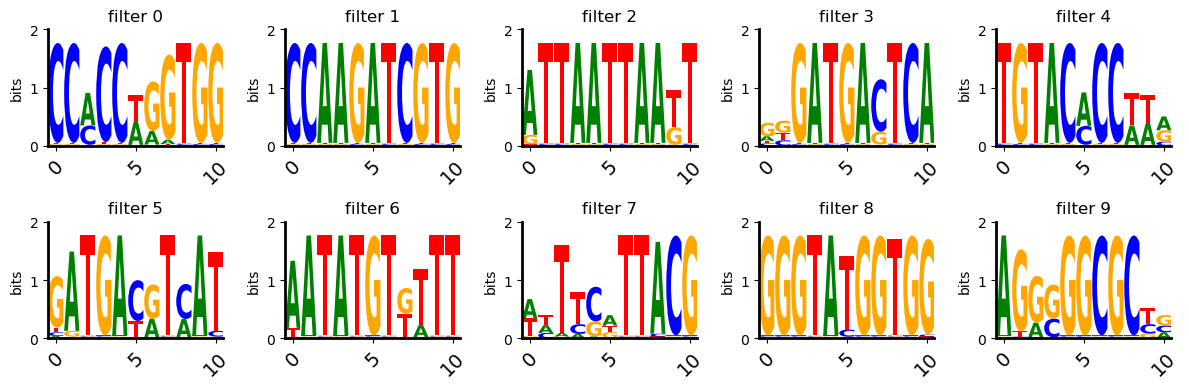

In [56]:
# Plot all the filters for the current model
pl.multifilter_viz(
    sdata_test,
    filter_nums=range(0, 10),
    pfms_key="arch.conv1d_tower.layers.1_pfms",
    num_rows=2,
    num_cols=5,
    figsize=(12, 4),
    titles=[f"filter {i}" for i in range(0, 10)],
    save=os.path.join(eu.settings.figure_dir, f"best_{model_type}_model_filters_viz.pdf")
)

# TomTom results

In [ ]:
# Get the significant hits to the HOCOMOCO database
model_type = "CNN"
res = pd.read_csv(os.path.join(eu.settings.output_dir, f"jund_best_{model_type}_model_filters_tomtom.tsv"), sep="\t", comment="#")
res_sig = res[res["q-value"] < 0.05].sort_values(by="q-value")

In [ ]:
# Check the most significant for each filter
res_sig.groupby("Query_ID").head(1)

In [ ]:
# Save as a dataframe
merged_df = pd.DataFrame()
for model in ["CNN", "Hybrid", "Kopp21CNN"]:
    x = res = pd.read_csv(os.path.join(eu.settings.output_dir, f"jund_best_{model_type}_model_filters_tomtom.tsv"), sep="\t", comment="#")
    x["model_type"] = model
    merged_df = pd.concat([merged_df, x])
merged_df = merged_df[~merged_df["Query_ID"].isna()]
merged_df.to_csv(os.path.join(eu.settings.output_dir, "all_models_filters_tomtom.tsv"), sep="\t", index=False)

---